In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, glob
from scipy.stats import linregress, norm

from bqplot import (
    LogScale, LinearScale, ColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip
)
import bqplot.marks as bqm
from IPython.display import display
import ipywidgets as widgets

plt.style.use('ggplot')

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#This uses data from AnAge, a curated database of animal specifications, part of the Human Ageing Genomic Resources

raw_data = pd.read_csv('PanTHERIA_1-0_WR05_Aug2008.txt', sep="\t")

#Remove species with missing data
data = raw_data[np.isfinite(raw_data['5-1_AdultBodyMass_g'])]
data = data[np.isfinite(data['17-1_MaxLongevity_m'])]
data = data[np.isfinite(data['18-1_BasalMetRate_mLO2hr'])]

data['Metabolic rate/Body mass (W/g)'] = data['18-1_BasalMetRate_mLO2hr']/data['5-1_AdultBodyMass_g']
data['Lifespan Constant'] = data['17-1_MaxLongevity_m'] * data['5-1_AdultBodyMass_g'] / data['18-1_BasalMetRate_mLO2hr']
data['Lifetime expenditure of energy (W/yrs/g)'] = data['18-1_BasalMetRate_mLO2hr']/data['17-1_MaxLongevity_m']/data['5-1_AdultBodyMass_g']

data = data.reset_index()

In [3]:
rodents = data[data['MSW05_Order']=='Rodentia']
carnivores = data[data['MSW05_Order']=='Carnivora']
bats = data[data['MSW05_Order']=='Chiroptera']
primates = data[data['MSW05_Order']=='Primates']

In [4]:
#data = data[(data['Sample size']=='large') | (data['Sample size']=='huge')]

# Lifespan vs. Body Mass

### Raw Data

Text(0.5,1,'Species Body Mass vs. Lifespan')

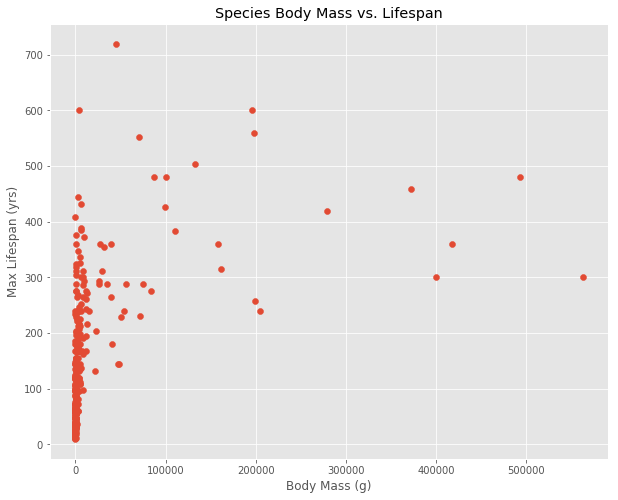

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(data['5-1_AdultBodyMass_g'], data['17-1_MaxLongevity_m'])
#plt.xlim(xmin=-2000,xmax=100000)
plt.xlabel('Body Mass (g)')
plt.ylabel('Max Lifespan (yrs)')
plt.title('Species Body Mass vs. Lifespan')

### Log Standardized Data

In [6]:
def update_line(change):
    lin.x = [np.min(fig_scat.x), np.max(fig_scat.x)]
    poly = np.polyfit(fig_scat.x, fig_scat.y, 1)
    lin.y = np.polyval(poly, lin.x)
    label.value = 'y = {:.2f} + {:.8f}x'.format(poly[1], poly[0])   

In [7]:
BM_min, BM_max = np.min(data['5-1_AdultBodyMass_g'].apply(np.min)), np.max(data['5-1_AdultBodyMass_g'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['17-1_MaxLongevity_m'].apply(np.min)), np.max(data['17-1_MaxLongevity_m'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=lifespan_min, max=lifespan_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Max Lifespan (yrs)'])

fig_scat = Scatter(x=data['5-1_AdultBodyMass_g'], y=data['17-1_MaxLongevity_m'], 
                      names=data['MSW05_Binomial'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=60, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Max Lifespan (yrs)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

label = widgets.Label()

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Maximum Lifespan Across Animal Species?')

box = widgets.VBox([fig])

display(box)

### Power Statistics

In [8]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['5-1_AdultBodyMass_g']), np.log(data['17-1_MaxLongevity_m']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and Lifespan: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and Lifespan: (0.21175381162626844, 0.26146671679951955)
The r^2 value for the relationship is 0.5179271460131741.
The associated p-value is 2.832829419065976e-53.


# Association Between Body Mass and BMR

#### Note: the asiatic elephant is an influential point

### Raw Data

Text(0.5,1,'Species Metabolic Rate vs. Body Mass')

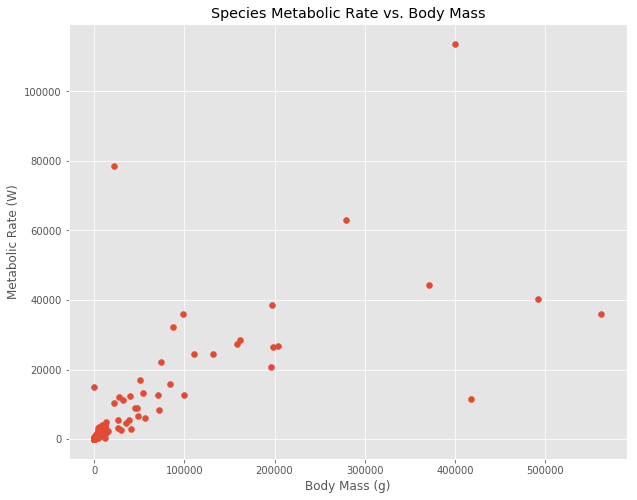

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(data['5-1_AdultBodyMass_g'], data['18-1_BasalMetRate_mLO2hr'])
#plt.xlim(xmin=-10000,xmax=500000)
#plt.ylim(ymin=-10,ymax=400)
plt.xlabel('Body Mass (g)')
plt.ylabel('Metabolic Rate (W)')
plt.title('Species Metabolic Rate vs. Body Mass')

### Log Standardized Data

In [10]:
BM_min, BM_max = np.min(data['5-1_AdultBodyMass_g'].apply(np.min)), np.max(data['5-1_AdultBodyMass_g'].apply(np.max))
BMR_min, BMR_max = np.min(data['18-1_BasalMetRate_mLO2hr'].apply(np.min)), np.max(data['18-1_BasalMetRate_mLO2hr'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['17-1_MaxLongevity_m'].apply(np.min)), np.max(data['17-1_MaxLongevity_m'].apply(np.max))

x_sc = LogScale(min=BM_min, max=BM_max)
y_sc = LogScale(min=BMR_min, max=BMR_max)

tt = Tooltip(fields=['name', 'x', 'y'], 
             labels=['Animal', 'Body Mass (g)', 'Metabolic Rate (W)'])

fig_scat = Scatter(x=data['5-1_AdultBodyMass_g'], y=data['18-1_BasalMetRate_mLO2hr'].round(decimals = 3),
                      names=data['MSW05_Binomial'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc},
                      default_size=40, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_y = Axis(label='Metabolic Rate (W)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')
ax_x = Axis(label='Body Mass (g)', scale=x_sc, grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y],
             title='Does Body Mass Affect Metabolic Rate Across Animal Species?')

fig

Figure(axes=[Axis(label='Body Mass (g)', scale=LogScale(max=562592.69, min=4.2)), Axis(label='Metabolic Rate (…

### Log Standardized Data with LoBF

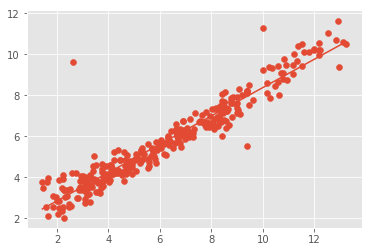

In [11]:
plt.scatter(np.log(data['5-1_AdultBodyMass_g']), np.log(data['18-1_BasalMetRate_mLO2hr']))
y = np.log(data['18-1_BasalMetRate_mLO2hr'])
x = np.log(data['5-1_AdultBodyMass_g'])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

### Power Statistics for Mammals

In [13]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['5-1_AdultBodyMass_g']), np.log(data['18-1_BasalMetRate_mLO2hr']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between BM and BMR for mammals: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and BMR for mammals and birds: (0.6666158995487855, 0.7136357046234177)
The r^2 value for the relationship is 0.9108493436625178.
The associated p-value is 3.860603062000327e-172.


#### Binned Data to Account for Mass Skew

In [14]:
bins = np.arange(np.log(data['5-1_AdultBodyMass_g']).min(), np.log(data['5-1_AdultBodyMass_g']).max(), .2)
groupsMB = data.groupby(np.digitize(np.log(data['5-1_AdultBodyMass_g']), bins))


In [15]:
slope1, intercept, r_value, p_value, std_err1 = linregress(np.log(groupsMB['5-1_AdultBodyMass_g'].mean()), np.log(groupsMB['18-1_BasalMetRate_mLO2hr'].mean()))
low_bound = slope1 - 1.96 * std_err1
high_bound = slope1 + 1.96 * std_err1

print('95% CI for power relationship between BM and max lifespan for mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between BM and max lifespan for mammals and birds: (0.6324267842672717, 0.739350200489926)
The r^2 value for the relationship is 0.9186419060980638.
The associated p-value is 3.42684845680325e-32.


# Testing Existence of Constants in Lifetime Energy Expenditure

### Association Between Metabolic Expenditure and Lifespan

In [19]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['Lifetime expenditure of energy (W/yrs/g)']), np.log(data['17-1_MaxLongevity_m']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for the slope: (-0.4833950776367207, -0.4316839484263804)
The r^2 value for the relationship is 0.7878175887010948.
The associated p-value is 4.213870640406952e-111.


Text(0.5,1,'Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

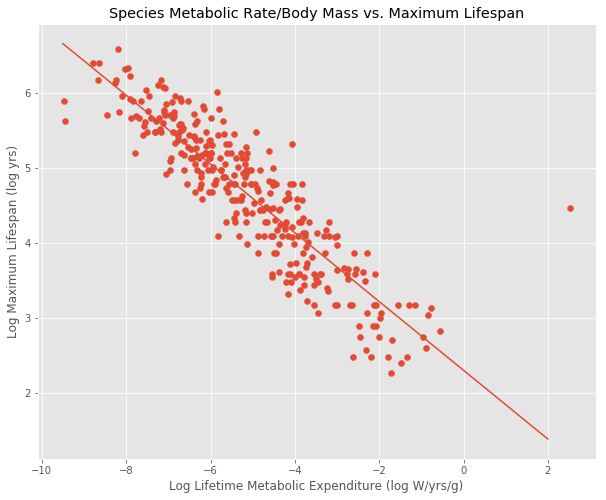

In [22]:
plt.figure(figsize=(10,8))
plt.scatter(np.log(data['Lifetime expenditure of energy (W/yrs/g)']), np.log(data['17-1_MaxLongevity_m']))
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(-9.5, 2)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.ylabel('Log Maximum Lifespan (log yrs)')
plt.title('Species Metabolic Rate/Body Mass vs. Maximum Lifespan')

Text(0.5,1,'Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

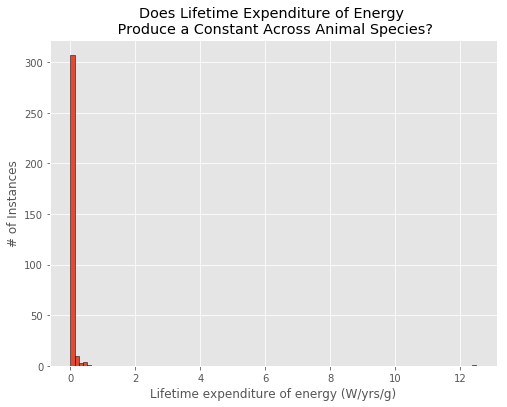

In [23]:
#temp_data = data[data['Lifespan Constant'] < 100000]
# Several outliers (11) exist past the 100,000 mark

plt.figure(figsize=(8,6))
plt.hist(data['Lifetime expenditure of energy (W/yrs/g)'], bins=100, ec="k")
plt.xlabel('Lifetime expenditure of energy (W/yrs/g)')
plt.ylabel('# of Instances')
plt.title('Does Lifetime Expenditure of Energy \n Produce a Constant Across Animal Species?')

### Association Between Body Mass and Metabolic Expenditure

In [24]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['5-1_AdultBodyMass_g']), np.log(data['Lifetime expenditure of energy (W/yrs/g)']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for the slope: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for the slope: (-0.582292457400677, -0.510676466852907)
The r^2 value for the relationship is 0.7341565683569113.
The associated p-value is 3.1794969177976404e-95.


Text(0.5,1,'Species Body Mass vs. Lifetime Energy Expenditure')

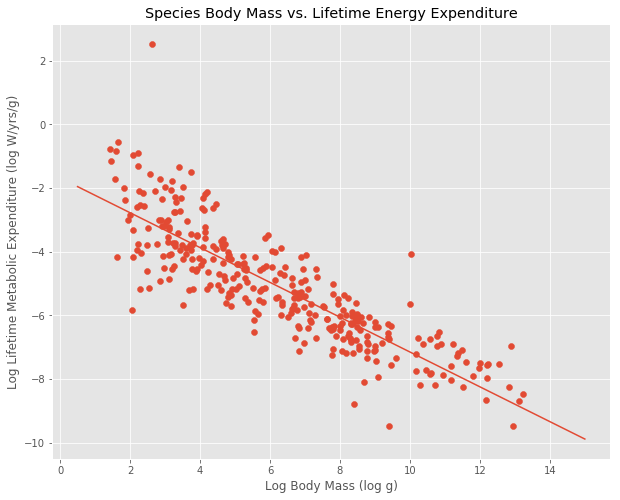

In [26]:
plt.figure(figsize=(10,8))
plt.scatter(np.log(data['5-1_AdultBodyMass_g']), np.log(data['Lifetime expenditure of energy (W/yrs/g)']))
#plt.xlim(xmin=-.001,xmax=0.05)

xfid = np.linspace(0.5, 15)
plt.plot(xfid, xfid*slope+intercept)

plt.xlabel('Log Body Mass (log g)')
plt.ylabel('Log Lifetime Metabolic Expenditure (log W/yrs/g)')
plt.title('Species Body Mass vs. Lifetime Energy Expenditure')

### Metabolic Rate vs. Lifespan

In [27]:
BM_min, BM_max = np.min(data['5-1_AdultBodyMass_g'].apply(np.min)), np.max(data['5-1_AdultBodyMass_g'].apply(np.max))
BMR_min, BMR_max = np.min(data['18-1_BasalMetRate_mLO2hr'].apply(np.min)), np.max(data['18-1_BasalMetRate_mLO2hr'].apply(np.max))
lifespan_min, lifespan_max = np.min(data['17-1_MaxLongevity_m'].apply(np.min)), np.max(data['17-1_MaxLongevity_m'].apply(np.max))

x_sc = LinearScale(min=BMR_min, max=BMR_max)
y_sc = LinearScale(min=lifespan_min, max=lifespan_max)
size_sc = LinearScale(min=BM_min, max=BM_max)

tt = Tooltip(fields=['name', 'x', 'y', 'size'], 
             labels=['Animal', '18-1_BasalMetRate_mLO2hr', 'Maximum lifespan (years)', '5-1_AdultBodyMass_g'])

fig_scat = Scatter(x=data['18-1_BasalMetRate_mLO2hr'].round(decimals = 3), y=data['17-1_MaxLongevity_m'], size=data['5-1_AdultBodyMass_g'],
                      names=data['MSW05_Binomial'], display_names=False,
                      scales={'x': x_sc, 'y': y_sc, 'size': size_sc},
                      default_size=800, tooltip=tt, animate=True, stroke='Black',
                      unhovered_style={'opacity': 0.5})

ax_x = Axis(label='Metabolic Rate (W)', scale=x_sc, grid_lines='solid')
ax_y = Axis(label='Maximum Lifespan (years)', scale=y_sc, orientation='vertical', side='left', grid_lines='solid')

fig = Figure(marks=[fig_scat], axes=[ax_x, ax_y], 
             title='How Does Metabolic Rate Correlate with Maximum Lifespan \n in Mammals and Birds?')
fig.layout.height = '600px'
fig.layout.width = '800px'

fig

Figure(axes=[Axis(label='Metabolic Rate (W)', scale=LinearScale(max=113712.0, min=7.7)), Axis(label='Maximum L…

In [28]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(data['18-1_BasalMetRate_mLO2hr']), np.log(data['17-1_MaxLongevity_m']))
low_bound = slope - 1.96 * std_err
high_bound = slope + 1.96 * std_err

print('95% CI for power relationship between metabolic rate and metabolic rate in mammals and birds: (' + str(low_bound) + ', ' + str(high_bound) + ')')
print('The r^2 value for the relationship is ' + str(r_value ** 2) + '.')
print('The associated p-value is ' + str(p_value) + '.')

95% CI for power relationship between metabolic rate and metabolic rate in mammals and birds: (0.2663960691754382, 0.3401657190614878)
The r^2 value for the relationship is 0.44494014996194536.
The associated p-value is 2.532707985136793e-43.


Text(0,0.5,'Maximum Lifespan (yrs)')

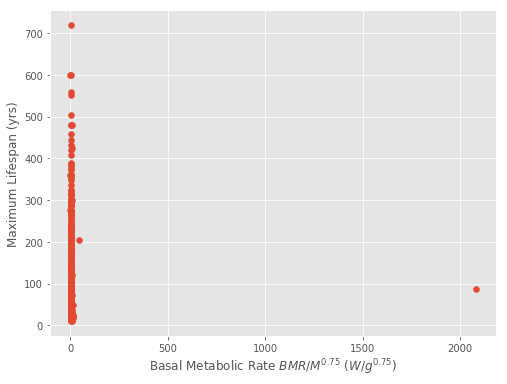

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(data['18-1_BasalMetRate_mLO2hr']/np.power(data['5-1_AdultBodyMass_g'], .75), data['17-1_MaxLongevity_m'])
plt.xlabel('Basal Metabolic Rate $BMR/M^{0.75}$ ($W/g^{0.75}$)')
plt.ylabel('Maximum Lifespan (yrs)')

